In [8]:
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

In [9]:
train_dir = './input/Train/Train'
test_dir = './input/Test/Test'
val_dir = './input/Validation/Validation'
seed = 16

In [10]:
train = image_dataset_from_directory(
    train_dir,  # Directory where the Training images are located
    labels = 'inferred', # Classes will be inferred according to the structure of the directory
    label_mode = 'categorical',
    class_names = ['Healthy', 'Powdery', 'Rust'],
    batch_size = 16,    # Number of processed samples before updating the model's weights
    image_size = (256, 256), # Defining a fixed dimension for all images
    shuffle = True,  # Shuffling data
    seed = seed,  # Random seed for shuffling and transformations
    validation_split = 0, # We don't need to create a validation set from the training set
    crop_to_aspect_ratio = True # Resize images without aspect ratio distortion
)

Found 1322 files belonging to 3 classes.


In [11]:
test = image_dataset_from_directory(
    test_dir,  
    labels = 'inferred', 
    label_mode = 'categorical',
    class_names = ['Healthy', 'Powdery', 'Rust'],
    batch_size = 16,    
    image_size = (256, 256), 
    shuffle = True,  
    seed = seed,  
    validation_split = 0, 
    crop_to_aspect_ratio = True 
)

Found 150 files belonging to 3 classes.


In [12]:
validation = image_dataset_from_directory(
    val_dir,  
    labels = 'inferred', 
    label_mode = 'categorical',
    class_names = ['Healthy', 'Powdery', 'Rust'],
    batch_size = 16,    
    image_size = (256, 256),
    shuffle = True,  
    seed = seed,  
    validation_split = 0, 
    crop_to_aspect_ratio = True 
)

Found 60 files belonging to 3 classes.


In [17]:
train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [18]:
test

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [19]:
validation

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [21]:
from tensorflow.keras.layers import Rescaling
scaler = Rescaling(1./255) # Defining scaler values between 0 to 1
# Rescaling datasets
train = train.map(lambda x, y: (scaler(x), y)) 
test = test.map(lambda x, y: (scaler(x), y))
validation = validation.map(lambda x, y: (scaler(x), y))

In [22]:
augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(factor = (-.25, .3),fill_mode = 'reflect',interpolation = 'bilinear',seed = seed),
        tf.keras.layers.RandomBrightness(factor = (-.45, .45),value_range = (0.0, 1.0),seed = seed),
        tf.keras.layers.RandomContrast(factor = (.5),seed = seed)
    ]
)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Activation, Dropout, BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
model = Sequential()

model.add(augmentation) # Adding data augmentation pipeline to the model

# Feature Learning Layers
model.add(Conv2D(32,                  # Number of filters/Kernels
                 (3,3),               # Size of kernels (3x3 matrix)
                 strides=1,           # Step size for sliding the kernel across the input (1 pixel at a time).
                 padding='same',      # 'Same' ensures that the output feature map has the same dimensions as the input by padding zeros around the input. 
                 input_shape=(256, 256, 3) # Input image shape
                ))
model.add(Activation('relu'))# Activation function
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(64, (5,5), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.3))

model.add(Conv2D(256, (5,5), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.3))

model.add(Conv2D(512, (3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(Dropout(0.3))

# Flattening tensors
model.add(Flatten())

# Fully-Connected Layers
model.add(Dense(2048))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(3, activation='softmax')) # Classification layer

In [25]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001), # 1e-4
              loss = 'categorical_crossentropy', # Ideal for multiclass tasks
              metrics = ['accuracy']) # Evaluation metric

In [28]:
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
early_stopping = EarlyStopping(monitor = 'val_accuracy',
                              patience = 5, mode = 'max',
                              restore_best_weights = True)

checkpoint = ModelCheckpoint('best_model.h5',
                            monitor = 'val_accuracy',
                            save_best_only = True)

In [30]:
model.fit(
    train,  # your training dataset
    epochs=50, 
    batch_size=83, 
    validation_data=validation,  # your validation dataset
    shuffle=True,
    callbacks=[early_stopping,checkpoint]
)

Epoch 1/50


83/83 [==============================] - ETA: 0s - loss: 5.8760 - accuracy: 0.5552

C:\Users\SYED JAVITH\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


83/83 [==============================] - 160s 2s/step - loss: 5.8760 - accuracy: 0.5552 - val_loss: 3.4510 - val_accuracy: 0.3333
Epoch 2/50
83/83 [==============================] - 154s 2s/step - loss: 2.5909 - accuracy: 0.6271 - val_loss: 11.8892 - val_accuracy: 0.3333
Epoch 3/50
83/83 [==============================] - 152s 2s/step - loss: 1.6893 - accuracy: 0.7065 - val_loss: 16.5523 - val_accuracy: 0.3333
Epoch 4/50
83/83 [==============================] - 156s 2s/step - loss: 1.0776 - accuracy: 0.7769 - val_loss: 21.0733 - val_accuracy: 0.3333
Epoch 5/50
83/83 [==============================] - 153s 2s/step - loss: 0.8343 - accuracy: 0.7995 - val_loss: 8.8169 - val_accuracy: 0.3333
Epoch 6/50
83/83 [==============================] - 158s 2s/step - loss: 0.7765 - accuracy: 0.8207 - val_loss: 5.0119 - val_accuracy: 0.3833
Epoch 7/50
83/83 [==============================] - 167s 2s/step - loss: 0.5731 - accuracy: 0.8533 - val_loss: 2.5270 - val_accuracy: 0.6000
Epoch 8/50
83/83 [===

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


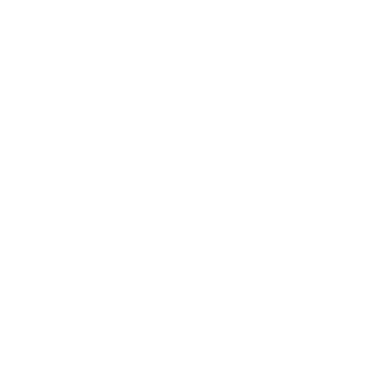

In [21]:
import matplotlib.pyplot as plt
image_batch, label_batch = next(iter(test))

# Assuming you want to visualize the first image in the batch
plt.imshow(image_batch[0].numpy())  # Convert the tensor to a numpy array and plot
plt.axis('off')  # Turn off axis
plt.show()

In [22]:
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')

In [25]:
from PIL import Image
import numpy as np
import tensorflow as tf

# Load the image
image_path = './input/Test/Test/Rust/82add70df6ab2854.jpg'
image = Image.open(image_path)

# Resize the image to match the input shape expected by your model
image = image.resize((256, 256))  # Assuming your model expects (256, 256) input shape

# Convert the image to a numpy array
image_array = np.array(image) / 255.0  # Normalize pixel values to [0, 1]

# Add batch dimension to the image
image_array = np.expand_dims(image_array, axis=0)

# Make a prediction
predictions = model.predict(image_array)

# Interpret the prediction results
predicted_class = np.argmax(predictions[0])  # Assuming single prediction, extract the class with highest probability
class_names = ['Normal', 'Powder', 'Rust']  # Replace with your actual class names
predicted_class_name = class_names[predicted_class]

print("Predicted class:", predicted_class_name)


1/1 [==============================] - 1s 573ms/step
Predicted class: class3
